**Instalação do Pytorch Geometric**

In [ ]:
# Primeiro, instalar o PyTorch
!pip install torch torchvision

# Verificar a versão do CUDA para instalar a versão correspondente do PyTorch Geometric
import torch
CUDA_VERSION = torch.version.cuda.replace('.', '')
print("Versão do CUDA:", CUDA_VERSION)

# Instalar o PyTorch Geometric
PYG_VERSION = '2.1.0'  # Escolha a versão de PyTorch Geometric que deseja instalar
TORCH_VERSION = torch.__version__.split('+')[0]

# Comandos para instalar o PyTorch Geometric e suas dependências
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-geometric=={PYG_VERSION}

Versão do CUDA: 121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html


**Instalação de Bibliotecas para Visualizações**

In [ ]:
!pip install networkx matplotlib

**Importar Bibliotecas**

In [ ]:
# Torch e Torch Geometric
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [ ]:
# Para Visualização de gráficos e grafos
import matplotlib.pyplot as plt
import networkx as nx

**Carregar Dataset**

In [ ]:
# Cora:
# - Tipo: Rede de citações.
# - Nós: 2.708 artigos científicos.
# - Arestas: 5.429 conexões de citações.
# - Features: Cada nó tem 1.433 atributos (bag-of-words).
# - Classes: 7 categorias de tópicos.
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# CiteSeer:
# - Tipo: Rede de citações.
# - Nós: 3.327 artigos científicos.
# - Arestas: 4.732 conexões de citações.
# - Features: Cada nó tem 3.703 atributos (bag-of-words).
# - Classes: 6 categorias de tópicos.
#dataset = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')

# PubMed:
# - Tipo: Rede de citações.
# - Nós: 19.717 artigos médicos.
# - Arestas: 44.338 conexões de citações.
# - Features: Cada nó tem 500 atributos (TF-IDF).
# - Classes: 3 categorias de doenças.
#dataset = Planetoid(root='/tmp/PubMed', name='PubMed')

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

**Definição dos Modelos de GCN**

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, neurons=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, neurons)
        self.conv2 = GCNConv(neurons, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
class ARMA(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ARMA, self).__init__()

        # Primeira camada ARMAConv
        self.conv1 = ARMAConv(
            in_channels=num_features,
            out_channels=16,
            num_stacks=3,
            num_layers=2,
            shared_weights=True,
            dropout=0.25
        )

        # Segunda camada ARMAConv
        self.conv2 = ARMAConv(
            in_channels=16,
            out_channels=num_classes,
            num_stacks=3,
            num_layers=2,
            shared_weights=True,
            dropout=0.25,
            act=lambda x: x  # Função de ativação identidade
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Aplicando dropout e a primeira camada
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv1(x, edge_index))

        # Aplicando dropout novamente e a segunda camada
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        # Retornando o log_softmax para classificação
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import APPNP

class APPNPNet(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(APPNPNet, self).__init__()

        # Configuração dos parâmetros da rede
        hidden = 64  # Número de neurônios na camada escondida
        K = 10       # Número de iterações de propagação
        alpha = 0.1  # Fator de teleportação

        # Camadas lineares
        self.lin1 = Linear(num_features, hidden)
        self.lin2 = Linear(hidden, num_classes)

        # Camada APPNP
        self.prop1 = APPNP(K, alpha)

    def reset_parameters(self):
        """Reinicializa os parâmetros das camadas."""
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        dropout = 0.5  # Taxa de dropout
        x, edge_index = data.x, data.edge_index

        # Passo 1: Dropout inicial
        x = F.dropout(x, p=dropout, training=self.training)

        # Passo 2: Primeira camada linear com ReLU
        x = F.relu(self.lin1(x))

        # Passo 3: Dropout adicional
        x = F.dropout(x, p=dropout, training=self.training)

        # Passo 4: Segunda camada linear
        x = self.lin2(x)

        # Passo 5: Propagação usando APPNP
        x = self.prop1(x, edge_index)

        # Passo 6: Log softmax para classificação
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import SGConv

class SGC(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SGC, self).__init__()

        # Camada SGConv
        self.conv1 = SGConv(
            in_channels=num_features,
            out_channels=num_classes,
            K=2,         # Número de hops
            cached=True  # Cache para grafos estáticos
        )

    def forward(self, data):
        """
        Forward principal com softmax para tarefas de classificação.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()

        # Primeira camada GATConv com múltiplas cabeças
        self.conv1 = GATConv(
            in_channels=in_channels,
            out_channels=8,  # Saída de cada cabeça
            heads=8,         # Número de cabeças de atenção
            dropout=0.6      # Dropout durante o cálculo da atenção
        )

        # Segunda camada GATConv com uma única cabeça
        # O número de canais de entrada é 8 * 8 (saídas da primeira camada * cabeças)
        self.conv2 = GATConv(
            in_channels=8 * 8,
            out_channels=out_channels,
            dropout=0.6
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Aplicar dropout na entrada
        x = F.dropout(x, p=0.6, training=self.training)

        # Primeira camada GATConv com função de ativação ELU
        x = F.elu(self.conv1(x, edge_index))

        # Aplicar dropout após a primeira camada
        x = F.dropout(x, p=0.6, training=self.training)

        # Segunda camada GATConv
        x = self.conv2(x, edge_index)

        # Retornar log_softmax para classificação
        return F.log_softmax(x, dim=1)

**Instanciar o Modelo e Preparar para Treinamento**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)  # escolha do modelo
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

**Definir Funções para Visualização**

In [ ]:
# Função para converter dados para NetworkX
def to_networkx(data):
    G = nx.Graph()
    for i in range(data.num_nodes):
        G.add_node(i)
    edge_index = data.edge_index.numpy()
    edges = zip(edge_index[0], edge_index[1])
    G.add_edges_from(edges)
    return G

In [ ]:
# Função para salvar gráficos de perdas
def save_loss_plot(train_losses, val_losses, test_losses, epoch):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses over Epochs (up to epoch {epoch + 1})')
    plt.legend()
    plt.grid()
    plt.savefig(f'loss_plot_epoch_{epoch + 1}.png')
    plt.close()

In [ ]:
# Função para salvar gráficos de acurácia
def save_accuracy_plot(val_accs, test_accs, train_accs, epoch):
    plt.figure()
    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.plot(train_accs, label='Train Accuracy')
    plt.title('Accuracy Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(f'accuracy_epoch_{epoch}.png')
    plt.close()

In [ ]:
# Função para salvar grafo com previsões
def save_graph_predictions(model, data, G, epoch):
    _, pred = model(data).max(dim=1)
    colors = [f'C{color}' for color in pred.cpu().numpy()]
    plt.figure(figsize=(8, 8))
    nx.draw(G, node_color=colors, node_size=35, linewidths=0.5, width=0.5, edge_color="gray")
    plt.title(f'Graph Predictions at Epoch {epoch + 1}')
    plt.savefig(f'graph_predictions_epoch_{epoch + 1}.png')
    plt.close()

**Definir Funções para Treinamento**

In [ ]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
data.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [ ]:
# Função para treinar o modelo em uma época
def train_model(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)

    # Calcular perda (loss)
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    # Retropropagação
    train_loss.backward()
    optimizer.step()

    # Calcular acurácia diretamente
    pred = out[data.train_mask].argmax(dim=1)  # Predições
    correct = (pred == data.y[data.train_mask]).sum().item()  # Acertos
    acc_train = correct / data.train_mask.sum().item()  # Acurácia

    return train_loss.item(), acc_train

In [ ]:
import torch

# Função para avaliar o modelo
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])

        # Calcular acurácias
        val_preds = out[data.val_mask].max(1)[1]  # Pega o índice da classe com maior probabilidade
        test_preds = out[data.test_mask].max(1)[1]
        val_acc = val_preds.eq(data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
        test_acc = test_preds.eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    return val_loss.item(), test_loss.item(), val_acc, test_acc

In [ ]:
# Função principal para executar o treinamento
def main_training_loop(model, optimizer, data, num_epochs=200):
    G = to_networkx(data)  # Criar o grafo
    train_losses, val_losses, test_losses = [], [], []
    val_accs, test_accs, train_accs = [], [], []  # Listas para acurácias

    for epoch in range(num_epochs):
        # Treino
        train_loss, train_acc = train_model(model, optimizer, data)
        train_losses.append(train_loss)

        # Avaliação
        val_loss, test_loss, val_acc, test_acc = evaluate_model(model, data)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        train_accs.append(train_acc)

        if ((epoch+1) % 10 == 0):
            print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Gerar gráficos em .png
    print("Plotting graphs and saving to files...")
    save_loss_plot(train_losses, val_losses, test_losses, epoch)
    save_accuracy_plot(val_accs, test_accs, train_accs, epoch)  # Adicionar uma função para salvar o gráfico de acurácia
    save_graph_predictions(model, data, G, epoch)

    print("Done!")

**Realizar Treinamento**

In [ ]:
main_training_loop(model, optimizer, data, num_epochs=200)

Epoch 10, Train Loss: 0.9628, Val Loss: 1.2244, Test Loss: 1.2125, Train Acc: 0.8857, Val Acc: 0.7540, Test Acc: 0.7780
Epoch 20, Train Loss: 0.3109, Val Loss: 0.8272, Test Loss: 0.7787, Train Acc: 0.9786, Val Acc: 0.7700, Test Acc: 0.7970
Epoch 30, Train Loss: 0.1292, Val Loss: 0.7449, Test Loss: 0.6691, Train Acc: 0.9857, Val Acc: 0.7720, Test Acc: 0.7890
Epoch 40, Train Loss: 0.0765, Val Loss: 0.7365, Test Loss: 0.6518, Train Acc: 0.9857, Val Acc: 0.7760, Test Acc: 0.7960
Epoch 50, Train Loss: 0.0529, Val Loss: 0.7270, Test Loss: 0.6376, Train Acc: 0.9929, Val Acc: 0.7760, Test Acc: 0.8020
Epoch 60, Train Loss: 0.0378, Val Loss: 0.7238, Test Loss: 0.6330, Train Acc: 1.0000, Val Acc: 0.7860, Test Acc: 0.8000
Epoch 70, Train Loss: 0.0393, Val Loss: 0.7323, Test Loss: 0.6373, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.8010
Epoch 80, Train Loss: 0.0484, Val Loss: 0.7427, Test Loss: 0.6483, Train Acc: 0.9929, Val Acc: 0.7840, Test Acc: 0.7980
Epoch 90, Train Loss: 0.0365, Val Loss: 

**Avaliação do Modelo**

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
accuracy = correct / int(data.test_mask.sum())
print(f'Accuracy: {accuracy}')

Accuracy: 0.801


**Visualização: Evolução do Treinamento e Grafo**

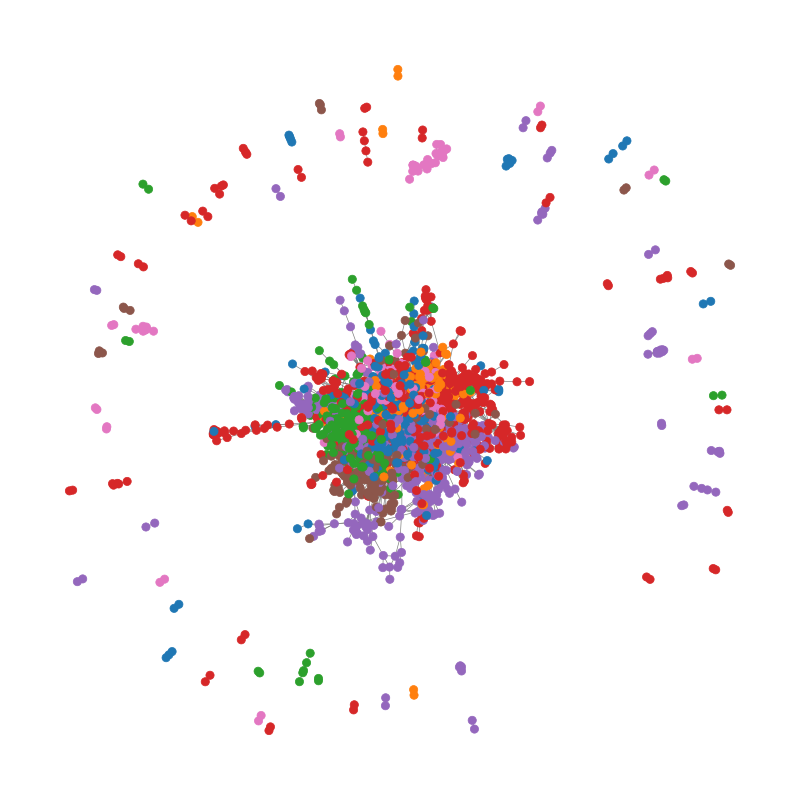

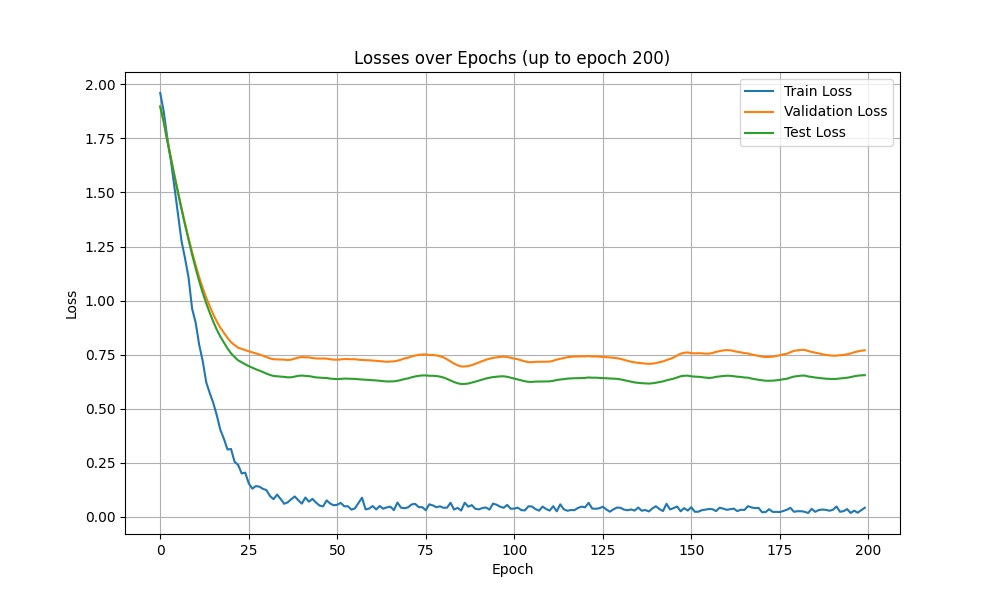

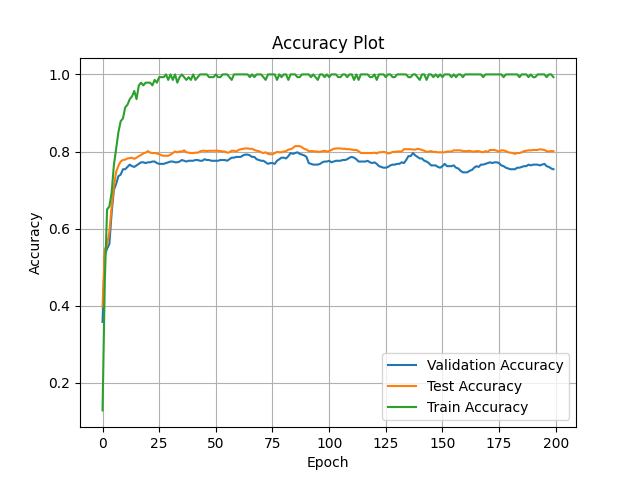

In [ ]:
import os
from IPython import display

image_width = 600

for x in os.listdir("."):
    if "graph_" in x:
        display.display(display.Image(x, width=image_width))

for x in os.listdir("."):
    if "loss_" in x:
        display.display(display.Image(x, width=image_width))

for x in os.listdir("."):
    if "accuracy_" in x:
        display.display(display.Image(x, width=image_width))